# Trotterization Exploration

The purpose of this notebook is to explore some currently available approximation methods to non-commuting Hamiltonian terms, and their associated computational complexities.

## Dynkin's Infinite Series for Baker-Campbell-Hausdorff Formula

In [150]:
import numpy as np
from math import factorial
import time

In [5]:
# Generate the allowed tuples to be permuted
# @order - The order, or word length, for which the terms are generated
# @k - Represents the number of tuples that contribute to each term
# @num_inputs - The number of inputs
# OUTPUT - A generator of tuples of length @num_inputs
def generate_allowed_tuples(order, k, num_inputs, *args):
    if args and len(args) == num_inputs:
        if sum(args) != 0 and sum(args) <= order:
            yield args
    else:
        if sum(args) <= order:
            for o in range(order + 1 - k + 1):
                yield from generate_allowed_tuples(order, k, num_inputs, *(args + (o,)))

In [35]:
# Generate the indices to be iterated over in the BCHD driver function
# @tuples - Allowed tuples to be permuted over
# @order - The order, or word length, for which the terms are generated
def generate_indices(tuples, order, *args):
    if not tuples:
        if sum(sum(pair) for pair in args) == order:
            yield args
    else:
        head = tuples[0]
        for h in head:
            if sum(sum(pair) for pair in args) + sum(h) <= order:
                yield from generate_indices(tuples[1:], order, *(args + (h,)))  

In [224]:
# TODO - Disallow non-square and differently dimensioned matrices
def bchd(inputs, order=2):
    correction = np.zeros(np.shape(inputs[0]))
    for o in range(1, order+1):
        print('Working with order', o, 'terms:')
        for k in range(1, o+1):
            print('k=', k, 'term contributions:')
            
            tuples = generate_allowed_tuples(o, k, len(inputs))
            allowed_tuples = []
            for at in tuples:
                allowed_tuples.append(at)
            coefficient = (-1)**(k-1)/k
            
            indices = generate_indices([allowed_tuples.copy() for _ in range(k)], o)
            
            output = ''
            for index in indices:
                denominator = '' # For output
                denom = 1 # For computation
                temp_correction = np.identity(np.shape(inputs[0])[0])
                for tups in index:
                    for t in range(len(tups)):
                        if tups[t]:
                            output += chr(ord('A') + t) + '^' + str(tups[t]) + ' '
                            denominator += str(tups[t]) + '!'
                            denom *= factorial(tups[t])
                            for _ in range(tups[t]):
                                temp_correction = temp_correction @ inputs[t]
                output += '/ (' + str(denominator) + ') + '
                correction += coefficient * temp_correction / denom
            
            print(output[:-2])
            
            print(20 * '-')
            print('Coefficient: ', coefficient)
        print(30 * '=', '\n')
    print('Corr:\n', correction)
    return correction

In [188]:
inputs = [
    np.array([[1,0,3], [0,1,3], [2,7,3]]),
    np.array([[5,2,3], [1,4,3], [7,5,8]]),
    np.array([[9,3,6], [8,3,4], [1,7,3]])
]
'''inputs = [
    np.identity(3),
    np.array([[5,2,3], [1,4,3], [3,3,3]]),
    #np.array([[7,2,7], [5,2,8], [7,7,7]])
]'''
'''inputs = [
    np.identity(5),
    np.identity(5),
    np.identity(5)
]'''

'inputs = [\n    np.identity(5),\n    np.identity(5),\n    np.identity(5)\n]'

In [165]:
start = time.time()
bchd(inputs, 5)
stop = time.time()

print(stop-start)

Working with order 1 terms:
k= 1 term contributions:
B^1 / (1!) + A^1 / (1!) 
--------------------
Coefficient:  1.0

Working with order 2 terms:
k= 1 term contributions:
B^2 / (2!) + A^1 B^1 / (1!1!) + A^2 / (2!) 
--------------------
Coefficient:  1.0
k= 2 term contributions:
B^1 B^1 / (1!1!) + B^1 A^1 / (1!1!) + A^1 B^1 / (1!1!) + A^1 A^1 / (1!1!) 
--------------------
Coefficient:  -0.5

Working with order 3 terms:
k= 1 term contributions:
B^3 / (3!) + A^1 B^2 / (1!2!) + A^2 B^1 / (2!1!) + A^3 / (3!) 
--------------------
Coefficient:  1.0
k= 2 term contributions:
B^1 B^2 / (1!2!) + B^1 A^1 B^1 / (1!1!1!) + B^1 A^2 / (1!2!) + B^2 B^1 / (2!1!) + B^2 A^1 / (2!1!) + A^1 B^2 / (1!2!) + A^1 A^1 B^1 / (1!1!1!) + A^1 A^2 / (1!2!) + A^1 B^1 B^1 / (1!1!1!) + A^1 B^1 A^1 / (1!1!1!) + A^2 B^1 / (2!1!) + A^2 A^1 / (2!1!) 
--------------------
Coefficient:  -0.5
k= 3 term contributions:
B^1 B^1 B^1 / (1!1!1!) + B^1 B^1 A^1 / (1!1!1!) + B^1 A^1 B^1 / (1!1!1!) + B^1 A^1 A^1 / (1!1!1!) + A^1 B^1 B

## Benchmarking

In [349]:
from contextlib import contextmanager
import sys, os
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm

In [350]:
def commutative_assumption(input_matrices):
    result = np.identity(np.shape(input_matrices[0])[0])
    for i in input_matrices:
        result = logm(expm(result).dot(expm(b)))
    return result

In [351]:
def flatten_correction(matrix):
    result = 0
    for row in matrix:
        for entry in row:
            result += abs(entry)
    return result

In [352]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

### 2x2 Matrix - Order versus Time

#### Random 2x2 Matrices

In [367]:
# Create random 2x2 matrices up to order @NUM_ORDERS
NUM_ORDERS = 10

input_matrices = [np.random.rand(2,2), np.random.rand(2,2)]
commuting = commutative_assumption(input_matrices)

lengths = np.array([])
corrections = np.array([])
diffs = np.array([])
for num_order in range(1, NUM_ORDERS+1):
    start = time.time()
    with suppress_stdout():
        corr = bchd(input_matrices, num_order)
        corrections = np.append(corrections, [corr])
        diffs = np.append(diffs, flatten_correction(commuting - corr))
    stop = time.time()
    lengths = np.append(lengths, stop - start)
    
print(lengths)
print(diffs)

[9.04798508e-04 6.70909882e-04 1.76191330e-03 4.98580933e-03
 1.69451237e-02 7.56506920e-02 2.09270000e-01 8.79426003e-01
 3.64500809e+00 1.61961901e+01]
[7.46369546 7.39177985 7.40129708 7.40674792 7.40551316 7.40499129
 7.40514079 7.4051928  7.4051753  7.40517001]


Matrix 1
[[0.49323402 0.42137089]
 [0.69635724 0.0379896 ]]
Matrix 2
[[0.48266418 0.36744453]
 [0.27349437 0.11515165]]


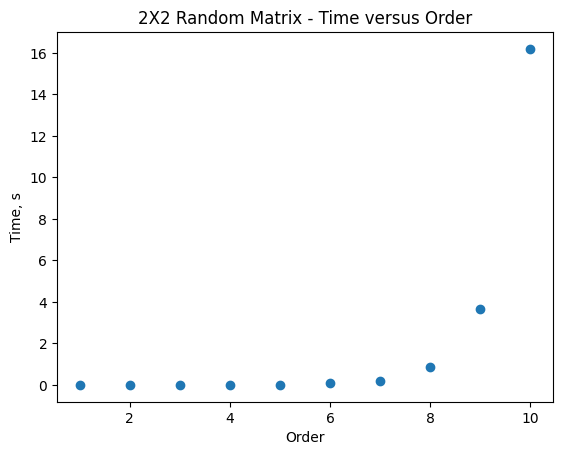

In [370]:
plt.scatter(range(1, NUM_ORDERS+1), lengths)
plt.title('2X2 Random Matrix - Time versus Order')
plt.xlabel('Order')
plt.ylabel('Time, s')
plt.savefig('2x2matrix_varying_order.jpg')

for i in range(len(input_matrices)):
    print('Matrix', i+1)
    print(input_matrices[i])

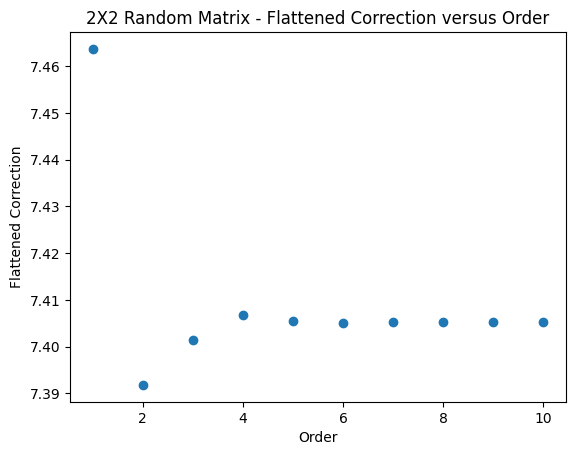

In [371]:
plt.scatter(range(1, NUM_ORDERS+1), diffs)
plt.title('2X2 Random Matrix - Flattened Correction versus Order')
plt.xlabel('Order')
plt.ylabel('Flattened Correction')
plt.savefig('2x2matrix_varying_order_corr.jpg')

#### Identity and Random 2x2 Matrix

In [356]:
# Create 2x2 random and idenity matrices up to order @NUM_ORDERS
NUM_ORDERS = 10

input_matrices = [np.identity(2), np.random.rand(2,2)]
commuting = commutative_assumption(input_matrices)

lengths = np.array([])
corrections = np.array([])
diffs = np.array([])
for num_order in range(1, NUM_ORDERS+1):
    start = time.time()
    with suppress_stdout():
        corr = bchd(input_matrices, num_order)
        corrections = np.append(corrections, [corr])
        diffs = np.append(diffs, flatten_correction(commuting - corr))
    stop = time.time()
    lengths = np.append(lengths, stop - start)
    
print(lengths)
print(diffs)

[6.20126724e-04 6.18934631e-04 1.44577026e-03 5.13505936e-03
 1.68261528e-02 7.75270462e-02 2.39396811e-01 8.70579958e-01
 4.00998139e+00 1.56959069e+01]
[6.87514083 6.87514083 6.87514083 6.87514083 6.87514083 6.87514083
 6.87514083 6.87514083 6.87514083 6.87514083]


Text(0.5, 0, 'Order')

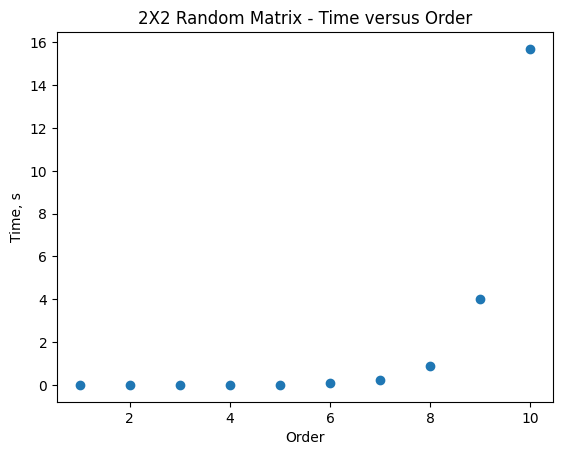

In [358]:
plt.scatter(range(1, NUM_ORDERS+1), lengths)
plt.title('2X2 Random Matrix - Time versus Order')
plt.ylabel('Time, s')
plt.xlabel('Order')

Text(0, 0.5, 'Flattened Correction')

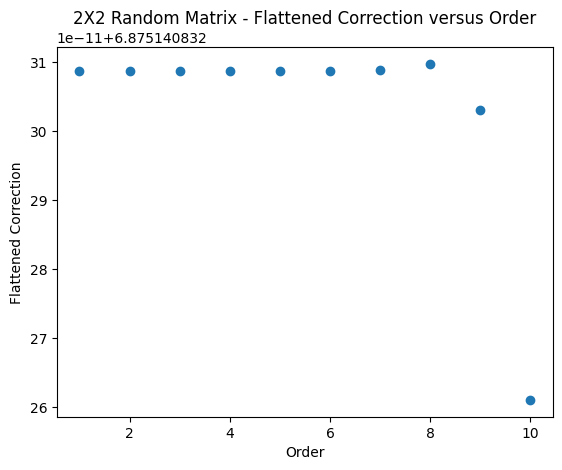

In [359]:
plt.scatter(range(1, NUM_ORDERS+1), diffs)
plt.title('2X2 Random Matrix - Flattened Correction versus Order')
plt.xlabel('Order')
plt.ylabel('Flattened Correction')

### Increase number of Order 2 Non-commuting Terms versus Time

In [373]:
# Create n random 2x2 matrices of order 2, where n up to @NUM_TERMS
NUM_TERMS = 50

input_matrices = [np.random.rand(2,2)]
lengths = np.array([])
diffs = np.array([])

for i in range(2, NUM_TERMS+1):
    input_matrices = np.append(input_matrices, [np.random.rand(2,2)], axis=0)
    start = time.time()
    with suppress_stdout():
        corr = bchd(input_matrices)
    stop = time.time()
    lengths = np.append(lengths, stop - start)
    diffs = np.append(diffs, flatten_correction(commutative_assumption(input_matrices) - corr))

Matrix 1
[[0.21756328 0.45063793]
 [0.92287558 0.84878294]]
Matrix 2
[[0.60755799 0.1147212 ]
 [0.97564167 0.49923219]]
Matrix 3
[[0.57540687 0.07391592]
 [0.45048325 0.08748608]]
Matrix 4
[[0.49125727 0.77962977]
 [0.4969275  0.05519772]]
Matrix 5
[[0.87516967 0.79129795]
 [0.75300488 0.34780677]]
Matrix 6
[[0.83011131 0.95736683]
 [0.98453148 0.83746473]]
Matrix 7
[[0.00990855 0.91215346]
 [0.83296319 0.53222351]]
Matrix 8
[[0.0428669  0.59320894]
 [0.70917152 0.9848486 ]]
Matrix 9
[[0.78642658 0.16159582]
 [0.43101733 0.64278266]]
Matrix 10
[[0.62233604 0.84801848]
 [0.49997529 0.68522051]]
Matrix 11
[[0.5355202  0.41967797]
 [0.68692285 0.63959433]]
Matrix 12
[[0.51850855 0.40015465]
 [0.86780065 0.18416021]]
Matrix 13
[[0.56420702 0.4829143 ]
 [0.61323403 0.41761316]]
Matrix 14
[[0.60902318 0.39088816]
 [0.38043925 0.22987477]]
Matrix 15
[[0.17966802 0.48176781]
 [0.3937452  0.54905897]]
Matrix 16
[[0.39650232 0.09260908]
 [0.70585208 0.37771315]]
Matrix 17
[[0.09190498 0.58286488

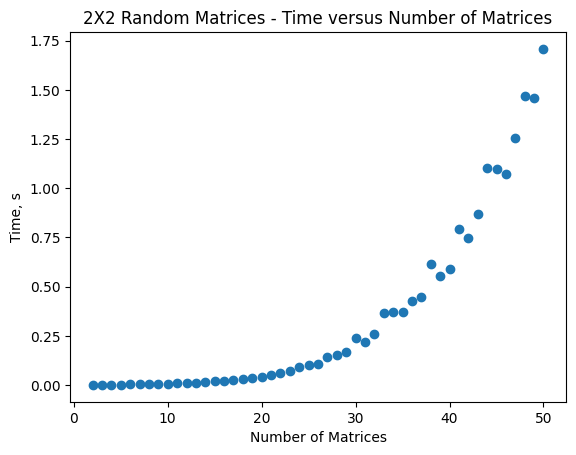

In [374]:
plt.scatter(range(2, NUM_TERMS+1), lengths)
plt.title('2X2 Random Matrices - Time versus Number of Matrices')
plt.xlabel('Number of Matrices')
plt.ylabel('Time, s')
plt.savefig('2x2matrix_order2_varying_terms.jpg')

for i in range(len(input_matrices)):
    print('Matrix', i+1)
    print(input_matrices[i])

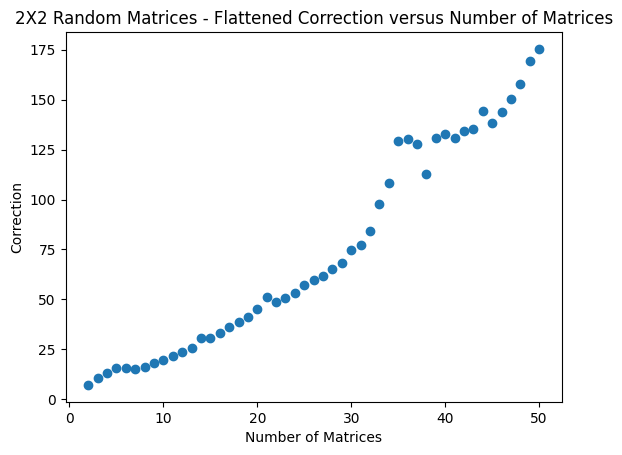

In [375]:
plt.scatter(range(2, NUM_TERMS+1), diffs)
plt.title('2X2 Random Matrices - Flattened Correction versus Number of Matrices')
plt.xlabel('Number of Matrices')
plt.ylabel('Correction')
plt.savefig('2x2matrix_order2_varying_terms_corr.jpg')

### Variable Matrix Size

In [380]:
# Create 5 random nxn matrices, where n up to @MATRIX_SIZE
MATRIX_SIZE = 500
NUM_MATRICES = 5

lengths = []
diffs = []
for n in range(2, MATRIX_SIZE+1):
    input_matrices = []
    for i in range(NUM_MATRICES):
        input_matrices.append(np.random.rand(n, n))
    start = time.time()
    with suppress_stdout():
        corr = bchd(input_matrices)
    stop = time.time()
    lengths.append(stop - start)
    #diffs.append(flatten_correction(commutative_assumption(input_matrices) - corr))

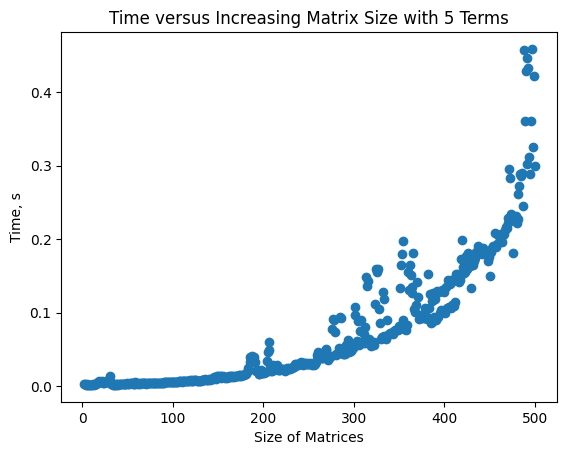

In [378]:
plt.scatter(range(2, MATRIX_SIZE+1), lengths)
plt.title('Time versus Increasing Matrix Size with ' + str(NUM_MATRICES) + ' Terms')
plt.xlabel('Size of Matrices')
plt.ylabel('Time, s')
plt.savefig('time_vs_matrix_size_5_terms.jpg')

TODO: Address the issue of compounding floating point errors for each of the scenarios above.

## Trotter-Suzuki Decomposition

In [183]:
def trotterize(inputs, num_steps=10, time=1):
    result = temp_result = np.identity(np.shape(inputs[0])[0])
    for i in inputs:
        print(i)
        temp_result = temp_result @ np.exp(i/num_steps)
    for _ in range(num_steps):
        result = result @ temp_result
    return result

In [190]:
trotterize(inputs, 1)

[[1 0 3]
 [0 1 3]
 [2 7 3]]
[[5 2 3]
 [1 4 3]
 [7 5 8]]
[[9 3 6]
 [8 3 4]
 [1 7 3]]


array([[1.91045042e+08, 6.62538150e+07, 1.04208987e+07],
       [1.89258288e+08, 6.62504160e+07, 1.03243313e+07],
       [3.99277563e+08, 9.17655657e+07, 1.56138800e+07]])